In [1]:
import math
import operator
import os
import random
import shutil
import socket
import sys
import json
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
# import torchvision
import wandb
from loss import *
from models import get_model
from datasets import get_datasets
from torch.utils.data import DataLoader
from utils.optimizers import *
from utils.util import *
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
from collections import defaultdict

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/conda/lib/python3.10/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', default=0, type=int)
parser.add_argument('--num_cpu_threads', default=8, type=int)
parser.add_argument('--batch_size', default=16, type=int)
parser.add_argument('--devset_size', default=384, type=int)
parser.add_argument('--ctx_size', default=4096, type=int)
parser.add_argument('--save_path', type=str)
parser.add_argument('--in_hess_path', type=str)
parser.add_argument('--base_model', type=str)
parser.add_argument('--sigma_reg', default=1e-2, type=float)
parser.add_argument('--sigma_reg2', default=1e-2, type=float)
parser.add_argument('--scale_override', default=-1, type=float)
parser.add_argument('--use_fp64', action='store_true')
parser.add_argument('--no_use_buffered', action='store_true')
parser.add_argument('--sample_proc', default=1, type=int)
parser.add_argument('--lowmem_ldlq', action='store_true')
parser.add_argument('--ft_lr', default=3e-6, type=float)
parser.add_argument('--ft_bs', default=4, type=int)
parser.add_argument('--ft_update_freq', default=1, type=int)
parser.add_argument('--ft_epochs', default=5, type=int)
parser.add_argument('--ft_valid_freq', default=1, type=int)
parser.add_argument('--ft_valid_size', default=128, type=float)
parser.add_argument('--ft_early_stop', default=5, type=int)
parser.add_argument('--ft_grad_ckpt', action='store_true')
parser.add_argument('--skip_list', default=None, type=str)

parser.add_argument("--bundle", action='store_true', default = True)
parser.add_argument("--ql", action='store_true')
parser.add_argument("--ql_path", type=str, default = None)
parser.add_argument("--hesseigen", type=str, default = None)
parser.add_argument("--gptq", action='store_true', default = False)
parser.add_argument("--ldlq", action='store_true', default = False)
parser.add_argument("--comp_model_path", type=str)
parser.add_argument("--direction", type=str, default='col')
parser.add_argument("--comp_batch_size", type=int, default=2048)
parser.add_argument('--quip_tune_iters', default=0, type=int)
parser.add_argument('--rescale_WH', action='store_true')
parser.add_argument('--rescale_WH_2', action='store_true')

parser.add_argument('--ql_invH', action='store_true', default=False)
parser.add_argument('--use_train_scale', action='store_true', default=False)
parser.add_argument('--layerwise_cdt', action='store_true', default=False)
parser.add_argument("-lr", "--learning_rate", default=1e-4, type=float)
parser.add_argument("--aux_learning_rate",
    default=1e-3,
    help="Auxiliary loss learning rate (default: %(default)s)",
)
args = parser.parse_args([]) 

In [3]:
def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        # layers = [model.model.layers, model.model.vision_tower.vision_tower.vision_model.encoder.layers]
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    else:
        raise NotImplementedError(type(model))
    return layers

def flat_to_sym(V, N):
    A = torch.zeros(N, N, dtype=V.dtype, device=V.device)
    idxs = torch.tril_indices(N, N, device=V.device)
    A[idxs.unbind()] = V
    A[idxs[1, :], idxs[0, :]] = V
    return A

def regularize_H(H, n, sigma_reg):
    H.div_(torch.diag(H).mean())
    idx = torch.arange(n)
    H[idx, idx] += sigma_reg
    return H

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)

def configure_optimizers(net, args):
    """Separate parameters for the main optimizer and the auxiliary optimizer.
    Return two optimizers"""

    parameters = {n for n, p in net.named_parameters() if ".quantiles" not in n and p.requires_grad}
    aux_parameters = {n for n, p in net.named_parameters() if ".quantiles" in n and p.requires_grad}

    print(aux_parameters)  # {'module.entropy_bottleneck_z.quantiles'}

    params_dict = dict(net.named_parameters())

    optimizer = optim.Adam(
        (params_dict[n] for n in sorted(parameters)),
        lr=args.learning_rate,
    )
    aux_optimizer = optim.Adam(
        (params_dict[n] for n in sorted(aux_parameters)),
        lr=args.aux_learning_rate,
    )
    return optimizer, aux_optimizer

In [4]:
import glob

args.comp_model_path = glob.glob("../NWC/checkpoint/nwc/block_seq_row_16/lmbda50_*/best_loss*.pth.tar")[0]
args.use_train_scale = True

model_name="meta-llama--Llama-2-7b-hf"
args.base_model = f"../Wparam_dataset/hf_model/{model_name}"
args.in_hess_path = "../Wparam_dataset/quip_hess/Hessians-Llama-2-7b-6144"

In [5]:
config = os.path.join(os.path.dirname(args.comp_model_path), 'config.json')
with open(config, 'r', encoding='utf-8') as file:
    config = json.load(file)
config = Config(**config)

shift, scale = None, None
if config.architecture == 'nwc_ql' and not hasattr(config, "Q"):
    config.Q = 4
comp_model = get_model(config.architecture, config, scale=scale, shift=shift)      
ckpt = torch.load(args.comp_model_path, weights_only=False)

if args.use_train_scale or args.layerwise_cdt:
    try:
        scale = ckpt["state_dict"]["scale"]
        shift = ckpt["state_dict"]["shift"]
        print('Use train scale and shift')
    except:
        scale, shift  = torch.zeros(1), torch.zeros(1)
else:
    if 'scale' in ckpt["state_dict"]:
        del ckpt["state_dict"]['scale']
    if 'shift' in ckpt["state_dict"]:
        del ckpt["state_dict"]['shift']
    shift, scale = utils.get_model_weight_stats(model, args, config.input_size)

comp_model.load_state_dict(ckpt["state_dict"], strict = False)
comp_model.scale = scale
comp_model.shift = shift
print(comp_model.scale.shape, comp_model.shift.shape)

Use train scale and shift
torch.Size([128, 16]) torch.Size([128, 16])


In [6]:
def count_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

print("Parameter count by module:\n")
for name, module in comp_model.named_children():
    print(f"[{name}] Total: {count_parameters(module):,} parameters")
    for subname, submodule in module.named_children():
        print(f"  └─ [{name}.{subname}] {count_parameters(submodule):,} parameters")
        
for param in comp_model.parameters():
    param.requires_grad = True

for param in comp_model.g_s.parameters():
    param.requires_grad = False
    
print("Parameter count by module:\n")
for name, module in comp_model.named_children():
    print(f"[{name}] Total: {count_parameters(module):,} parameters")
    for subname, submodule in module.named_children():
        print(f"  └─ [{name}.{subname}] {count_parameters(submodule):,} parameters")
for name, param in comp_model.named_parameters():
    print(f"{name}: {param.shape} {param.requires_grad} {param.dtype} {param.device}")

Parameter count by module:

[g_a] Total: 280,592 parameters
  └─ [g_a.0] 8,704 parameters
  └─ [g_a.1] 263,680 parameters
  └─ [g_a.2] 8,208 parameters
[g_s] Total: 280,592 parameters
  └─ [g_s.0] 8,704 parameters
  └─ [g_s.1] 263,680 parameters
  └─ [g_s.2] 8,208 parameters
[entropy_bottleneck] Total: 976 parameters
  └─ [entropy_bottleneck.likelihood_lower_bound] 0 parameters
Parameter count by module:

[g_a] Total: 280,592 parameters
  └─ [g_a.0] 8,704 parameters
  └─ [g_a.1] 263,680 parameters
  └─ [g_a.2] 8,208 parameters
[g_s] Total: 0 parameters
  └─ [g_s.0] 0 parameters
  └─ [g_s.1] 0 parameters
  └─ [g_s.2] 0 parameters
[entropy_bottleneck] Total: 976 parameters
  └─ [entropy_bottleneck.likelihood_lower_bound] 0 parameters
g_a.0.weight: torch.Size([512, 16]) True torch.float32 cpu
g_a.0.bias: torch.Size([512]) True torch.float32 cpu
g_a.1.stack.0.lin_1.0.weight: torch.Size([512, 512]) True torch.float32 cpu
g_a.1.stack.0.lin_1.0.bias: torch.Size([512]) True torch.float32 cpu
g

In [7]:
device = torch.device('cuda:0')

model = AutoModelForCausalLM.from_pretrained(args.base_model,
                                                 torch_dtype='auto',
                                                 low_cpu_mem_usage=True,
                                                 local_files_only=True,)

Loading checkpoint shards: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


In [8]:
comp_model.scale = comp_model.scale.mean(0, keepdim=True)
comp_model.shift = comp_model.shift.mean(0, keepdim=True)

In [9]:
def hessian_weighted_loss2(W, W_hat, H):
    diff = W_hat - W
    H = H.float()
    trace_H = H.trace()
    if trace_H > 0:
        H = H / trace_H * (1.0 / W.numel())
    loss = torch.trace(diff @ H @ diff.T)     # scalar
    return loss


class RateDistortionLoss(nn.Module):
    def __init__(self, std, Hr, lmbda):
        super().__init__()
        self.mse = nn.MSELoss()
        self.lmbda = lmbda
        self.std = std
        self.Hr = Hr

    def hessian_weighted_loss(self, W, W_hat, H):
        diff = W_hat - W
        H = H.float()
        trace_H = H.trace()
        if trace_H > 0:
            H = H / trace_H * (1.0 / W.numel())
        loss = torch.trace(diff @ H @ diff.T)     # scalar
        return loss

    def forward(self, ori_W, output, ori_shape):
        out = {}
        num_pixels = output["x"].numel()
        # H = self.Hr[start_idx:end_idx][start_idx:end_idx]
        # out["recon_loss"] = self.mse(output["x"], output["x_hat"]) / self.std**2
        out["adaptive_loss"] = self.hessian_weighted_loss(ori_W.view(ori_shape), output["x_hat"].view(ori_shape), self.Hr) / self.std**2
        out["bpp_loss"] = sum(
            (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
            for likelihoods in output["likelihoods"].values()
        )

        out["loss"] = self.lmbda * out["adaptive_loss"] + out["bpp_loss"]
        return out

In [10]:
blocks = get_blocks(model) 
layers = get_named_linears(blocks[0])

ori_W = layers['self_attn.q_proj'].weight.data

in_hess_path = f'{args.in_hess_path}/{0}_{"qkv"}.pt'
H_data = torch.load(in_hess_path, map_location=torch.device('cpu'))
HR = flat_to_sym(H_data['flatH'], H_data['n'])
n_h = H_data['n']
if 'mu' in H_data:
    mu = H_data['mu']
    HR += mu[None, :] * mu[:, None]
    del mu
del H_data


comp_model.train()
comp_model.to(device)
HR = HR.to(device)

mse_fn = torch.nn.MSELoss()
loss_fn = RateDistortionLoss(std=comp_model.scale.mean(), Hr=HR, lmbda=10000)

bs = 1024
step = 0
result = defaultdict(list)
test_result = defaultdict(list)
pe = nn.Parameter(torch.zeros(ori_W.shape), requires_grad=True)
comp_model.pe = pe

optimizer, aux_optimizer = configure_optimizers(comp_model, args)
total = sum(p.numel() for group in optimizer.param_groups for p in group['params'])
print(f"Optimizer is tracking {total:,} parameters.")
total = sum(p.numel() for group in aux_optimizer.param_groups for p in group['params'])
print(f"Optimizer is tracking {total:,} parameters.")


for epoch in tqdm(range(50)):
    W_hat = torch.zeros(ori_W.shape)
    
    for start_idx in range(0, ori_W.shape[0], bs):
        
        optimizer.zero_grad()
        
        end_idx = min(start_idx + bs, ori_W.shape[0])
        w = ori_W[start_idx:end_idx] + comp_model.pe[start_idx:end_idx]
        ori_shape = w.shape
        w = w.reshape(ori_shape[0], -1, comp_model.input_size).to(device)
        data = {}
        data['weight_block'] = w
        out = comp_model(data)
    
        loss = loss_fn(ori_W[start_idx:end_idx].to(device), out, ori_shape)
        loss['loss'].backward()
        
        optimizer.step()
        try:
            aux_loss = comp_model.aux_loss()
        except:
            aux_loss = comp_model.module.aux_loss()
            
        aux_loss.backward()
        aux_optimizer.step()

        mse = mse_fn(ori_W[start_idx:end_idx].to(device), out["x_hat"].reshape(ori_shape))/loss_fn.std**2
        
        result['loss'].append(loss['loss'].item())
        result['adaptive_loss'].append(loss['adaptive_loss'].item())
        result['bpp_loss'].append(loss['bpp_loss'].item())
        result['mse'].append(mse.item())
        result['step'].append(step)
        
        # if epoch % 1 == 0 or epoch == 99:
        #     print(f"Step {step:3d} | Loss: {loss['adaptive_loss'].item():.4f} | BPP: {loss['bpp_loss']:.4f} | MSE: {mse.item():.4f} | ")
        step += 1
        W_hat[start_idx:end_idx] = out["x_hat"].reshape(ori_shape)
    
    test_result['adaptive_loss'].append(hessian_weighted_loss2(W_hat.to(device), ori_W.to(device), HR).item())
    

{'entropy_bottleneck.quantiles'}
Optimizer is tracking 17,058,736 parameters.
Optimizer is tracking 48 parameters.


100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


In [11]:
pe

Parameter containing:
tensor([[ 0.0054,  0.0081,  0.0020,  ..., -0.0032, -0.0006,  0.0037],
        [-0.0094,  0.0038, -0.0025,  ...,  0.0059,  0.0077, -0.0055],
        [ 0.0091, -0.0076,  0.0003,  ..., -0.0045, -0.0088,  0.0022],
        ...,
        [ 0.0011, -0.0091,  0.0009,  ..., -0.0076,  0.0099, -0.0079],
        [-0.0092, -0.0082, -0.0035,  ...,  0.0101,  0.0089,  0.0079],
        [ 0.0086,  0.0064, -0.0028,  ..., -0.0091, -0.0089,  0.0078]],
       requires_grad=True)

Text(0.5, 1.0, 'test adaptive_loss')

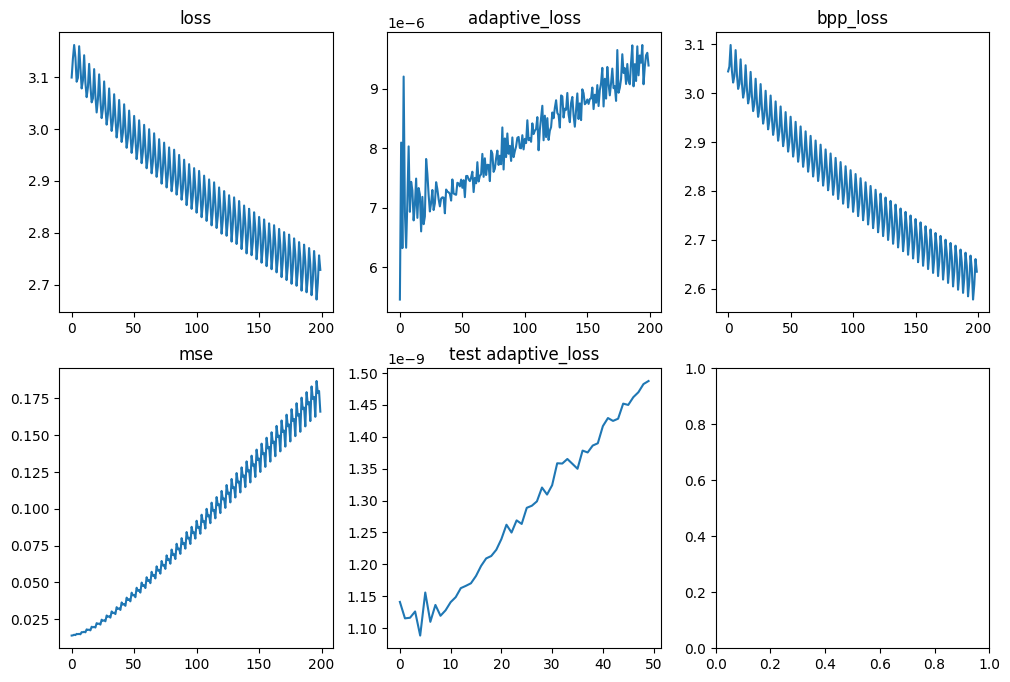

In [12]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, len(result)//2+1, figsize=(12, 8))

axs[0, 0].plot(result['step'], result['loss'], label='loss')
axs[0, 0].set_title('loss')
axs[0, 1].plot(result['step'], result['adaptive_loss'], label='adaptive_loss')
axs[0, 1].set_title('adaptive_loss')
axs[0, 2].plot(result['step'], result['bpp_loss'], label='bpp_loss')
axs[0, 2].set_title('bpp_loss')
axs[1, 0].plot(result['step'], result['mse'], label='mse')
axs[1, 0].set_title('mse')
axs[1, 1].plot(range(50), test_result['adaptive_loss'], label='adaptive_loss')
axs[1, 1].set_title('test adaptive_loss')